![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 17 - Boosting</center>
### <center> Random Forests</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/14_Boosting/MainRandomForest1.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

# np.random.seed(1)
# %matplotlib notebook

### Load the Titanic dataset:

In [2]:
from sklearn.datasets import fetch_openml
dData, vY         = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
dData['Survived'] = vY

In [3]:
lClasses = ['Died', 'Survived']
dData

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,Survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None,0
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None,0
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None,0
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None,0


### Quick look at the columns:

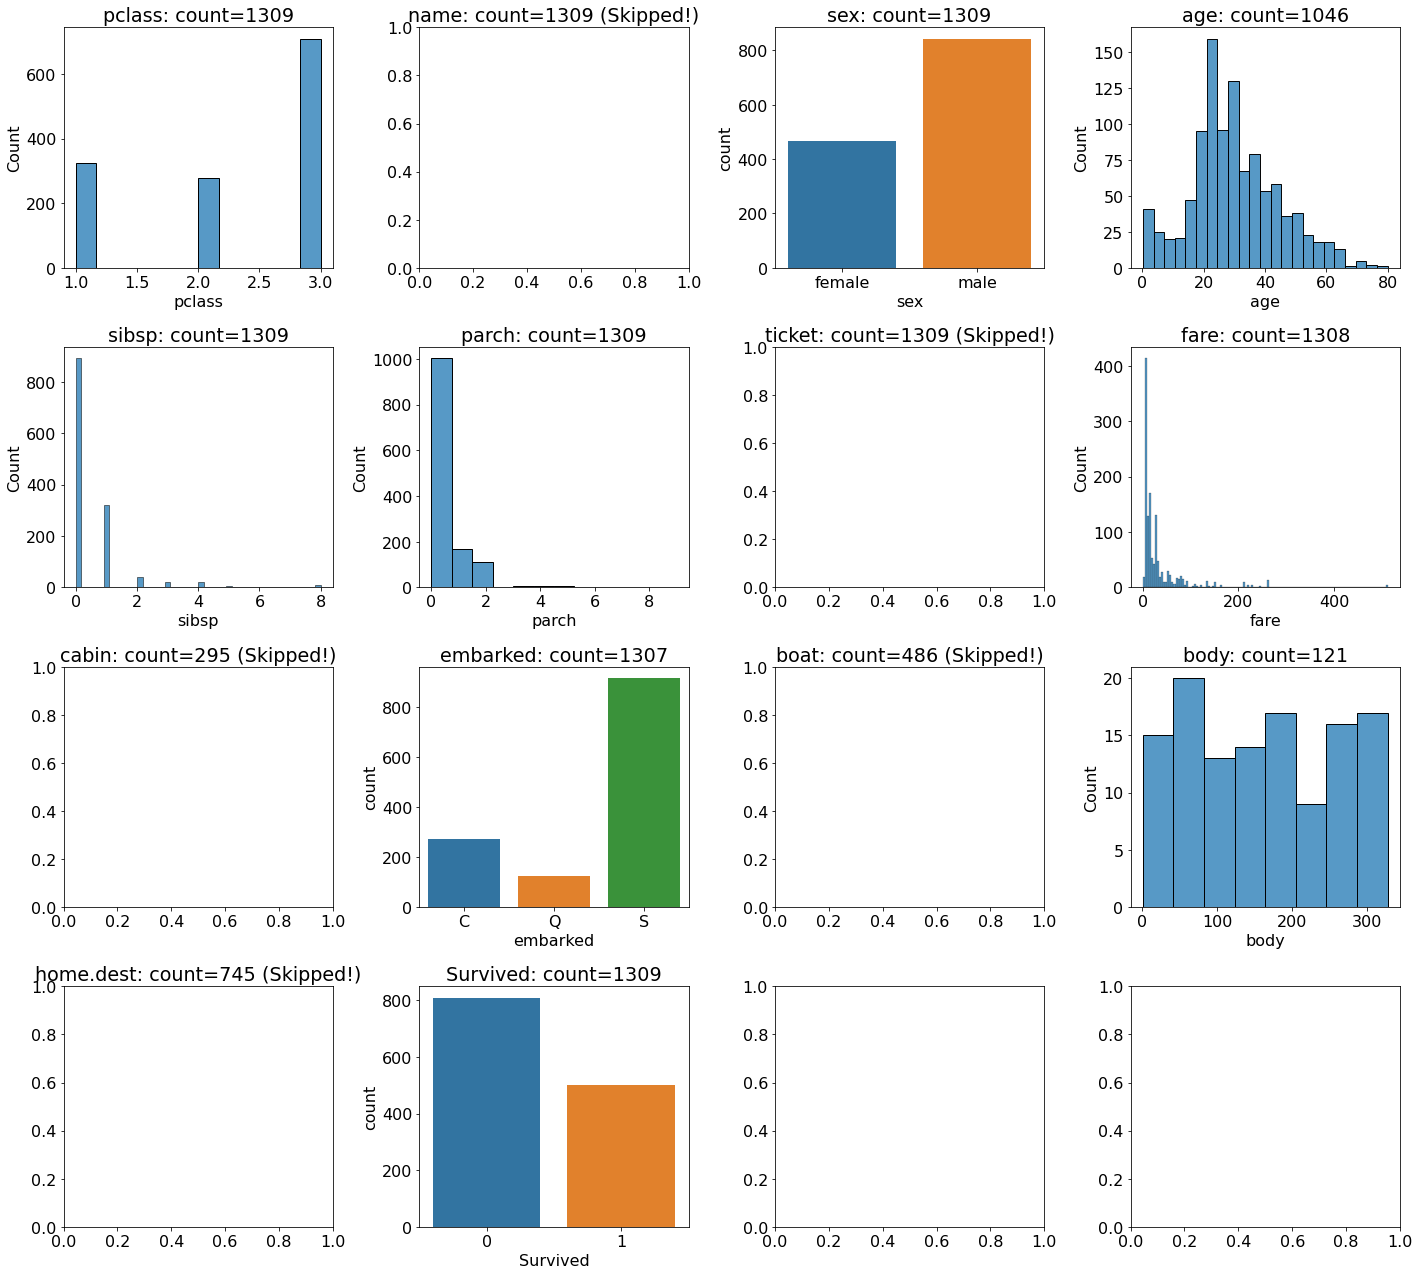

In [4]:
kk = 0
fig, _ = plt.subplots(4, 4, figsize=(20, 18))
for col in dData.columns:
    title = f'{col}: count={dData[col].count()}'
    if pd.api.types.is_numeric_dtype(dData[col]):
        sns.histplot(dData[col], ax=fig.axes[kk])
#         sns.histplot(data=dData, x=col, ax=fig.axes[kk])
    elif len(dData[col].unique()) < 10:
        sns.countplot(x=dData[col], ax=fig.axes[kk])
    else:
        title += ' (Skipped!)'
    fig.axes[kk].set_title(title)
    kk += 1;
plt.tight_layout()
plt.show()

### Remove columns:

In [5]:
# dData.drop(columns=['name', 'ticket', 'cabin', 'boat', 'home.dest'], inplace=True)
dData.drop(columns=['name', 'ticket', 'cabin', 'boat', 'home.dest', 'body'], inplace=True)
dData

,pclass,sex,age,sibsp,parch,fare,embarked,Survived
0,1.0,female,29.0000,0.0,0.0,211.3375,S,1
1,1.0,male,0.9167,1.0,2.0,151.5500,S,1
2,1.0,female,2.0000,1.0,2.0,151.5500,S,0
3,1.0,male,30.0000,1.0,2.0,151.5500,S,0
4,1.0,female,25.0000,1.0,2.0,151.5500,S,0
...,...,...,...,...,...,...,...,...
1304,3.0,female,14.5000,1.0,0.0,14.4542,C,0
1305,3.0,female,NaN,1.0,0.0,14.4542,C,0
1306,3.0,male,26.5000,0.0,0.0,7.2250,C,0
1307,3.0,male,27.0000,0.0,0.0,7.2250,C,0


### Check for NaNs:

In [6]:
dData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   sex       1309 non-null   category
 2   age       1046 non-null   float64 
 3   sibsp     1309 non-null   float64 
 4   parch     1309 non-null   float64 
 5   fare      1308 non-null   float64 
 6   embarked  1307 non-null   category
 7   Survived  1309 non-null   category
dtypes: category(3), float64(5)
memory usage: 55.4 KB


### Fill NaNs:
* Categorigal data can be filled with the most frequent value (mode).
* Numerical data can be filled with the median (or average).

In [7]:
#-- col : value
dNaNs = {
    'embarked' : dData['embarked'].mode()[0],
    'age'      : dData['age']     .median(),
    'fare'     : dData['fare']    .median(),
#     'body'     : dData['body']    .median(),
}

dData.fillna(value=dNaNs, inplace=True)

In [8]:
dData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   sex       1309 non-null   category
 2   age       1309 non-null   float64 
 3   sibsp     1309 non-null   float64 
 4   parch     1309 non-null   float64 
 5   fare      1309 non-null   float64 
 6   embarked  1309 non-null   category
 7   Survived  1309 non-null   category
dtypes: category(3), float64(5)
memory usage: 55.4 KB


### Use dummy variables for categorical columns:

In [9]:
dData = pd.get_dummies(dData, drop_first=True)
dData

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,Survived_1
0,1.0,29.0000,0.0,0.0,211.3375,0,0,1,1
1,1.0,0.9167,1.0,2.0,151.5500,1,0,1,1
2,1.0,2.0000,1.0,2.0,151.5500,0,0,1,0
3,1.0,30.0000,1.0,2.0,151.5500,1,0,1,0
4,1.0,25.0000,1.0,2.0,151.5500,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1304,3.0,14.5000,1.0,0.0,14.4542,0,0,0,0
1305,3.0,28.0000,1.0,0.0,14.4542,0,0,0,0
1306,3.0,26.5000,0.0,0.0,7.2250,1,0,0,0
1307,3.0,27.0000,0.0,0.0,7.2250,1,0,0,0


In [10]:
dData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   float64
 1   age         1309 non-null   float64
 2   sibsp       1309 non-null   float64
 3   parch       1309 non-null   float64
 4   fare        1309 non-null   float64
 5   sex_male    1309 non-null   uint8  
 6   embarked_Q  1309 non-null   uint8  
 7   embarked_S  1309 non-null   uint8  
 8   Survived_1  1309 non-null   uint8  
dtypes: float64(5), uint8(4)
memory usage: 56.4 KB


### Split to train and test:
When using random forest we can use out of bag error instead of cross-validation.  
Here, we do it to just for comparison.

In [11]:
from sklearn.model_selection import train_test_split

dTrainX, dTestX, vTrainY, vTestY = train_test_split(dData.drop(columns=['Survived_1']), vY, stratify=vY)
dTrainX

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
494,2.0,24.0,1.0,1.0,37.0042,0,0,0
354,2.0,25.0,1.0,0.0,26.0000,1,0,1
630,3.0,27.0,0.0,0.0,7.7958,1,0,1
1167,3.0,28.0,0.0,0.0,7.7292,1,1,0
129,1.0,35.0,0.0,0.0,211.5000,0,0,0
...,...,...,...,...,...,...,...,...
715,3.0,29.0,0.0,0.0,8.0500,1,0,1
205,1.0,65.0,0.0,0.0,26.5500,1,0,1
902,3.0,28.0,1.0,2.0,23.4500,1,0,1
1285,3.0,32.5,0.0,0.0,9.5000,1,0,1


### Train a random forest:

In [12]:
from sklearn.ensemble import RandomForestClassifier

oRandomForest = RandomForestClassifier(oob_score=True).fit(dTrainX, vTrainY)

In [13]:
print(f'Train accuracy:      {oRandomForest.score(dTrainX, vTrainY)}')
print(f'Out of bag accuracy: {oRandomForest.oob_score_}')
print(f'Test accuracy:       {oRandomForest.score(dTestX, vTestY)}')

Train accuracy:      0.9734964322120285
Out of bag accuracy: 0.7981651376146789
Test accuracy:       0.7957317073170732


### Feature importance - mean decrease in impurity:

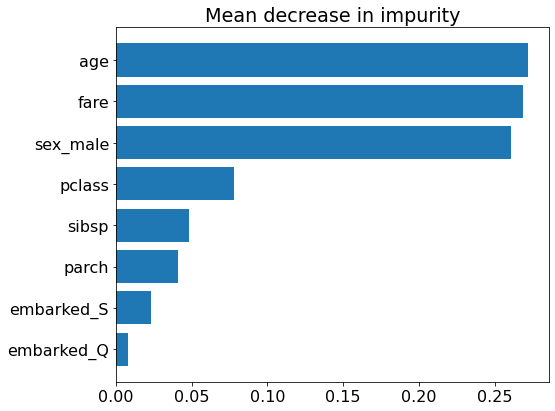

In [14]:
vFeatureImportances = oRandomForest.feature_importances_
vIdx                = vFeatureImportances.argsort()

vTicks = np.arange(0, len(vIdx))
plt.figure(figsize=(8,6))
plt.barh(vTicks, vFeatureImportances[vIdx])
plt.yticks(vTicks, dData.columns[vIdx])
plt.title('Mean decrease in impurity')
plt.tight_layout()
plt.show()

### Feature importance - permutation importance:

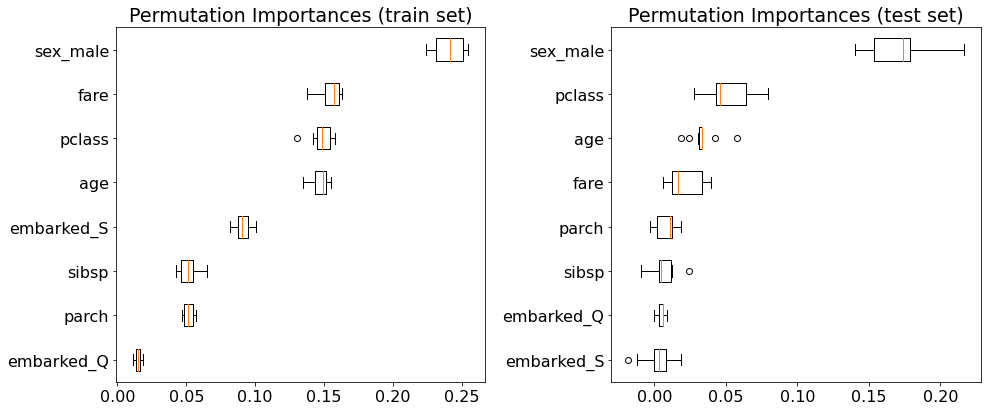

In [26]:
from sklearn.inspection import permutation_importance

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
oPremImp = permutation_importance(oRandomForest, dTrainX, vTrainY, n_repeats=10)
vIdx     = oPremImp.importances_mean.argsort()
plt.boxplot(oPremImp.importances[vIdx].T, vert=False, labels=dData.columns[vIdx])
plt.title('Permutation Importances (train set)')

plt.subplot(1,2,2)
oPremImp = permutation_importance(oRandomForest, dTestX, vTestY, n_repeats=10)
vIdx     = oPremImp.importances_mean.argsort()
plt.boxplot(oPremImp.importances[vIdx].T, vert=False, labels=dData.columns[vIdx])
plt.title('Permutation Importances (test set)')

plt.tight_layout()
plt.show()